# Staż Techmo - zadania

Poniżej znajdują się 3 zadania, które należy rozwiązać poprzez napisanie odpowiedniego kodu (w komórkach pod treścią zadania w pliku **staz.ipynb**), pozwalającego na wykonanie wymaganych w zadaniu obliczeń i prezentacje wyników. Przy rozwiązywaniu zadań można korzystać z dowolnych paczek dostępnych w managerze Pip np. numpy, pandas, librosa itp.

Notebook z rozwiązaniem oraz dane wrzuć na swojego githuba razem z plikiem *requirements.txt* pozwalającym na łatwą instalacje wszystkich wymaganych paczek.

In [ ]:
!pip install -r requirements.txt
import numpy as np
import IPython
from IPython.core.display import display
from matplotlib import pyplot as plt
import librosa
from librosa import display
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
import json
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
#personal preference
#warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 1. Przetwarzanie sygnałów

* Wczytaj plik dźwiękowy *audio.wav*
* Wstaw widget z audioplayerem tak, aby można było odsłuchać plik
* Narysuj **oscylogram**
* Wyznacz i narysuj przebieg tonu podstawowego **F0**
* Wyznacz i narysuj w skali decybelowej krótkoczasowe widmo sygnału (**STFT**). Dobierz odpowiednie wg Ciebie parametry analizy. Uzasadnij swój wybór.
* Wyznacz i narysuj w skali decybelowej wartości **MFCC** (13 współczynników). Parametry analizy pozostaw takie jak w kroku poprzednim.

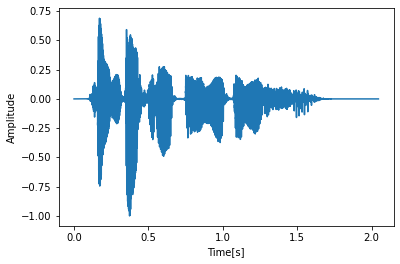

In [ ]:
#wczytanie pliku
y, fs = librosa.load('audio.wav')
display_Audio = lambda y,fs : IPython.display.display(IPython.display.Audio(y,rate=fs))
display_Audio(y,fs)

#oscylogram
plt.figure()
t = np.linspace(0,len(y)/fs,len(y))
plt.plot(t,y)
plt.ylabel('Amplitude')
plt.xlabel('Time[s]')
plt.show()

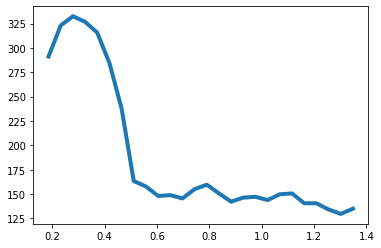

In [ ]:
#przebieg f0
#wyznaczony za pomoca gotowych metod  z pakietu librosa
f0, voiced_flag, voiced_probs=librosa.pyin(y, fmin=50, fmax=400, sr=fs, frame_length=2048, hop_length=1024, resolution=0.1, center=True, pad_mode='reflect')
fig, ax = plt.subplots()
t = np.linspace(0,len(y)/fs,len(f0))
ax.plot(t,f0,linewidth=4)



parametry okna - stacjonarnosc sygnalu mowy to okolo 20-30ms, chcemy +- takie okno
* 25ms=0.025s, fs*0.025= +-550 -> okno 512,

overlapp 1/4 pozwala na duza pewnosc ze stacjonarmy fragment jest w jednej ramce

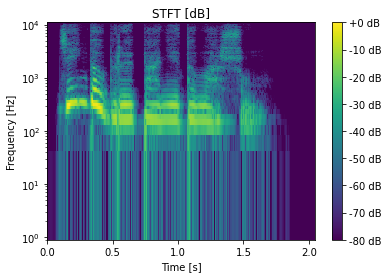

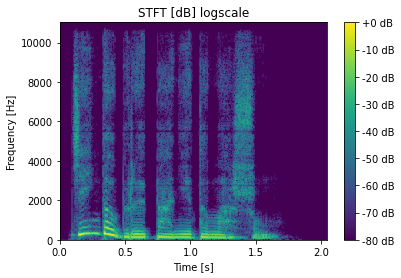

In [ ]:
#stft db
win=512
hop=1/4

#stft z osia f w skali logarytmicznej

#zdecydowalem na rysowanie w plt a nie w librosie (specshow), bo kolorystyka byla nieczytelna 
D=librosa.stft(y, n_fft=win, hop_length=int(hop*win), win_length=None, window='hann', center=False)

fig, ax = plt.subplots()

ax.set_yscale('log')
ax.set_ylim([0, fs/2])
t=np.linspace(0,len(y)/fs,D.shape[1])
f=np.linspace(0,fs/2,D.shape[0])
img = plt.pcolormesh(t,f,librosa.amplitude_to_db(np.abs(D), ref=np.max))
fig.colorbar(img, ax=ax,format="%+2.0f dB")
plt.title("STFT [dB]")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

#stft z osia f w skali liniowej
fig, ax = plt.subplots()
ax.set_yscale('linear')
ax.set_ylim([0, fs/2])
img = plt.pcolormesh(t,f,librosa.amplitude_to_db(np.abs(D), ref=np.max))
fig.colorbar(img, ax=ax,format="%+2.0f dB")
plt.title("STFT [dB] logscale")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

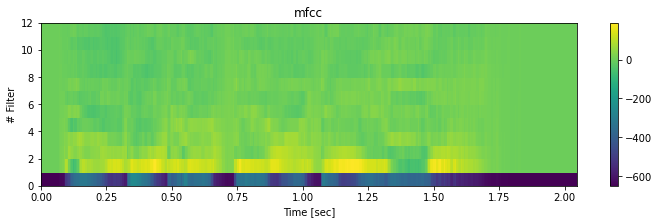

In [ ]:
n_mfcc =13
mfcc_librosa=librosa.feature.mfcc(y=y, sr=fs, n_mfcc=13, norm='ortho', lifter=0, n_fft=win,
                                  hop_length=int(hop*win), win_length=None, window='hann', center=False)
#wektor t jak wczesniej
f=np.arange(0,n_mfcc)
fig = plt.figure(figsize=(12, 3))
im1 = plt.pcolormesh(t, f, mfcc_librosa)
plt.title('mfcc')
plt.xlabel("Time [sec]")
plt.ylabel('# Filter')
fig.colorbar(im1)

## 2. Metryki

W pliku *predicted.json* zapisane są wyniki rozpoznania systemu ASR, służącego do rozpoznawania cyfr.

Dla każdej cyfry od 0 do 9 w słowniku przedstawione są wartości, jakie system rozpoznał dla kolejnych nagrań danej cyfry. 

Oblicz i przedstaw w formie tabeli **macierz pomyłek** (confusion matrix) oraz oblicz **skuteczność** systemu.

[[47  0  0  0  0  1  0  1  1  0]
 [ 0 45  0  0  1  0  0  3  1  0]
 [ 1  0 45  0  0  1  0  0  3  0]
 [ 0  0  0 45  3  0  2  0  0  0]
 [ 0  0  0  1 44  0  2  3  0  0]
 [ 0  0  0  0  0 40  0  0  0 10]
 [ 0  0  0  0  0  0 47  0  0  3]
 [ 0  0  0  0  0  0  0 49  1  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  3  0  0  0 47]]

skutecznosc systemu wynosi: 91.8 %


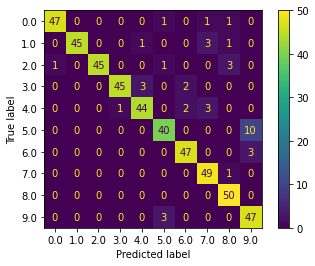

In [ ]:
with open('predicted.json') as json_file:
    data = json.load(json_file)
    y_pred=[]
    y_true=[]
    for key in data.keys():
      y_t=np.ones((len(data[key])))*int(key)
      y_p= [int(i) for i in data[key]]
      y_true=np.concatenate([y_true,y_t])
      y_pred=np.concatenate([y_pred,y_p])


cm=confusion_matrix(y_true=y_true,y_pred=y_pred)
#postac macierzowa macierzy bledow
print(cm)

print("\nskutecznosc systemu wynosi: "+str(100*(1-(cm-np.multiply(np.identity(len(cm)),cm)).sum()/len(y_true)))+" %" )

#postac graficzna macierzy bledow
y_true=y_true.reshape(-1, 1)
y_pred=y_pred.reshape(-1, 1)
clf = SVC(random_state=0)
clf.fit(y_true, y_true) 
SVC(random_state=0)
plot_confusion_matrix(clf, y_pred, y_true)  
plt.show()



## 3. Algebra

W plikach tekstowych `matrix_P.txt` oraz `matrix_Q.txt` znajduje się po 8 pomiarów 4-wymiarowej zmiennej (8 wierszy po 4 wartości).
* Wczytaj macierze do osobnych zmiennych `P` , `Q`.
* Korzystając z biblioteki `numpy` zaimplementuj funkcję obliczającą wzór:

$$
D_{KL}(P, Q) = \frac{1}{2} \mathrm{tr}\{(\boldsymbol{\Sigma}_p^{-1} + \boldsymbol{\Sigma}_q^{-1})(\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)(\boldsymbol{\mu}_p - \boldsymbol{\mu}_q)^T + \boldsymbol{\Sigma}_p \boldsymbol{\Sigma}_q^{-1} + \boldsymbol{\Sigma}_q \boldsymbol{\Sigma}_p^{-1} - 2 \boldsymbol{I}\}
$$

gdzie:

$\mathrm{tr}$ – ślad macierzy (trace)

$\boldsymbol{\Sigma}$ – macierz kowariancji

$\boldsymbol{\mu}$ – uśredniony wektor ze wszystkich pomiarów

$\boldsymbol{I}$ – macierz jednostkowa

> Dla podanych danych funkcja powinna zwrócić wartość ok. 6.03

In [ ]:
#wczytywanie plikow
f=open("matrix_P.txt","r")
rows=f.read().split("\n")
f=open("matrix_Q.txt","r")
rows2=f.read().split("\n")
rows=rows[:-1]
rows2=rows2[:-1]
P=np.zeros((8,4))
Q=np.zeros((8,4))
for j in range(len(rows)):
  row = [int(i) for i in rows[j].split(" ")]
  row2 = [int(i) for i in rows2[j].split(" ")]
  P[j,:]=row
  Q[j,:]=row2

In [ ]:
#implementacja oraz wywolanie funkcji
def dkl(P,Q): 
  mip=np.matrix(np.mean(P,axis=0)).T
  miq=np.matrix(np.mean(Q, axis=0)).T
  covp=(np.cov(P.T))
  covq=(np.cov(Q.T))
  covp_1=np.linalg.pinv(covp)
  covq_1=np.linalg.pinv(covq)
  s=np.dot((covp_1+covq_1),(mip- miq))
  s=np.dot(s,(mip-miq).T)
  s=s+np.dot(covp,covq_1)+np.dot(covq,covp_1)-2*np.identity(4)
  result=np.trace(s)/2
  return result
print(dkl(P,Q))

6.033482453811377
